# Building Demand Method 1 Simplified

#### Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'DemandMappingZambia':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\DemandMappingZambia


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona

# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
# %matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters

### Define directories and dataset names

In [5]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

In [6]:
# ## RWI layer
# rwi_path = in_path + "/Residential/Data/WealthIndex"
# rwi_name = 'zmb_relative_wealth_index.csv'

In [7]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Define area of interest

In [8]:
try: area
except NameError: area = "COUNTRY"
# area = "Copperbelt"

In [9]:
## Regions list
regions_path = "admin/"
regions_list = 'Regions_list.csv'
df_regions = pd.read_csv(regions_path + regions_list)
regions = df_regions['Regions GADM']
if area != "COUNTRY":
    regions = [area]
regions

0       Copperbelt
1         Muchinga
2    North-Western
3          Western
4          Luapula
5         Northern
6          Central
7         Southern
8          Eastern
9           Lusaka
Name: Regions GADM, dtype: object

### Import layers to be used

In [10]:
# ## Import Relative Wealth Index | convert to geodf | export as gpkg
# rwi = pd.read_csv(rwi_path + "/" + rwi_name)
# rwi_gdf = gpd.GeoDataFrame(rwi, geometry=gpd.points_from_xy(rwi.longitude, rwi.latitude), crs={'init': 'epsg:4326'})
# rwi_gdf.to_file(os.path.join(rwi_path,"{c}".format(c=rwi_name.split(".")[0])), driver="GPKG")

In [11]:
hexagons = gpd.read_file(out_path + "\\" + "h3_grid_at_hex_7.shp")

In [12]:
grid = hexagons

In [13]:
grid

,hexagons,lon,lat,index_righ,NAME_1,id,geometry
0,87399485cffffff,30.52,-12.18,5.00,Muchinga,1,"POLYGON ((30.53691 -12.18031, 30.52690 -12.190..."
1,873995215ffffff,30.42,-10.43,7.00,Northern,2,"POLYGON ((30.43731 -10.42986, 30.42750 -10.440..."
2,87344b340ffffff,25.31,-16.22,8.00,Southern,3,"POLYGON ((25.32539 -16.22858, 25.31506 -16.238..."
3,87344b340ffffff,25.31,-16.22,9.00,Western,4,"POLYGON ((25.32539 -16.22858, 25.31506 -16.238..."
4,873993948ffffff,29.12,-10.38,3.00,Luapula,5,"POLYGON ((29.12888 -10.38607, 29.11906 -10.396..."
...,...,...,...,...,...,...,...
122983,87344e845ffffff,27.77,-16.97,8.00,Southern,122984,"POLYGON ((27.78733 -16.97162, 27.77686 -16.981..."
122984,873990888ffffff,29.57,-11.40,3.00,Luapula,122985,"POLYGON ((29.58761 -11.40013, 29.57769 -11.410..."
122985,8739b1631ffffff,32.00,-11.33,5.00,Muchinga,122986,"POLYGON ((32.01484 -11.33869, 32.00494 -11.349..."
122986,873990729ffffff,29.14,-11.05,3.00,Luapula,122987,"POLYGON ((29.15715 -11.05241, 29.14726 -11.062..."


## Extract raster values to hexagons

Extract count of buildings per hex from WorldPop

In [14]:
pathWorldPopBuiCount = "Residential/Data/WorldPop/ZMB_buildings_v2_0_count.tif"
# grid = processing_raster("buildings", "count", grid, filepath=pathWorldPopBuiCount)
grid = processing_raster("buildings", "sum", grid, filepath=pathWorldPopBuiCount) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/
# pathWorldPopBuiArea = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_total_area.tif"
# grid = processing_raster("bui_area_WP", "sum", grid, filepath=pathWorldPopBuiArea) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2024-06-24 10:53:12.755313


Extract urban areas from WorldPop

In [15]:
pathWorldPopBuiUrban = "Residential/Data/WorldPop/ZMB_buildings_v2_0_urban.tif"
grid = processing_raster("locationWP", "median", grid, filepath=pathWorldPopBuiUrban)      #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2024-06-24 11:02:00.936312


Extract lighing data

In [16]:
## set_lightscore_sy_xxxx.tif: Predicted likelihood that a settlement is electrified (0 to 1)
## http://www-personal.umich.edu/~brianmin/HREA/data.html
# pathHREA = "Residential/Data/Lighting/Copperbelt_set_lightscore_sy_2019_Nodata_values_fixed.tif"
pathHREA = "Residential/Data/Lighting/Zambia_set_lightscore_sy_2019.tif"
grid = processing_raster("HREA", "mean", grid, filepath=pathHREA)
probElec= "HREA"

2024-06-24 13:05:24.427674


Extract RWI

In [17]:
# Relative Wealth Index (RWI) -- extracting the mean value per building
# Link: https://gee-community-catalog.org/projects/rwi/
pathRWI = "Residential/Data/WealthIndex/rwi_map.tif"
grid = processing_raster("rwi", "mean", grid, filepath=pathRWI)

2024-06-24 13:26:05.441521


Extract tiers Falchetta dataset

In [18]:
# extract tiers share from Falchetta dataset #https://www.nature.com/articles/s41597-019-0122-6#Sec7
pathElecAccess = "Residential/Data/Falchetta_ElecAccess/Zambia_tiersofaccess_2018.tif"
grid = processing_raster("tiers", "majority", grid, filepath=pathElecAccess)

2024-06-24 13:37:17.162161


Extract GDP Kummu dataset 

In [19]:
#Link https://www.nature.com/articles/sdata20184#Sec9
pathGDP = "Residential/Data/GDP/GDP_PPP_30arcsec_v3_band3_Zambia.tif"
grid = processing_raster("GDP_PPP", "mean", grid, filepath=pathGDP)

2024-06-24 13:48:29.152713


##### Once done with rasters run this cell

In [20]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2024-06-24 13:49:34.491936


In [21]:
grid.rename({'HREAmean': 'HREA'}, axis=1, inplace=True)
grid.rename({'rwimean': 'rwi'}, axis=1, inplace=True)
grid.rename({'locationWPmedian': 'locationWP'}, axis=1, inplace=True)
grid.rename({'tiersmajority': 'tiers'}, axis=1, inplace=True)
grid.rename({'GDP_PPPmean': 'GDP_PPP'}, axis=1, inplace=True)

Add values in RWI column when there is none

In [22]:
grid["rwi"].fillna(grid["rwi"].mean(numeric_only=True).round(1), inplace=True)
print(grid["rwi"].min())
print(grid["rwi"].max())

-1.2319999933242798
1.496250033378601


In [23]:
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,tiers,GDP_PPP,geometry
0,87399485cffffff,30.52,-12.18,5.00,Muchinga,1,57.00,0.00,0.03,-0.81,0.00,NaN,"POLYGON ((30.53691 -12.18031, 30.52690 -12.190..."
1,873995215ffffff,30.42,-10.43,7.00,Northern,2,NaN,NaN,NaN,-0.40,0.00,NaN,"POLYGON ((30.43731 -10.42986, 30.42750 -10.440..."
2,87344b340ffffff,25.31,-16.22,8.00,Southern,3,NaN,NaN,0.09,-0.40,0.00,NaN,"POLYGON ((25.32539 -16.22858, 25.31506 -16.238..."


## Extract residential demand from UN stats

In [24]:
# Residential energy demand at the country level
energyBalance_path = "EnergyBalance/"
file_energyBalance = "UNSD+DF_UNData_EnergyBalance+1.0_Zambia.csv"
eb = pd.read_csv(energyBalance_path + file_energyBalance)
code_elec = "B07_EL"
code_hh =  "B50_1231"
total_residentialenergy_TJ = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_hh) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
total_residentialenergy_TJ = pd.to_numeric(total_residentialenergy_TJ.str.replace(',', '')) # convert to numeric and remove commas
total_residentialenergy_GWh = total_residentialenergy_TJ.iloc[0]/3.6 # conversion in GWh
print("Residential electricity consumption", total_residentialenergy_GWh, "GWh")

Residential electricity consumption 4022.5 GWh


### Step 1: assess the number of HH with access

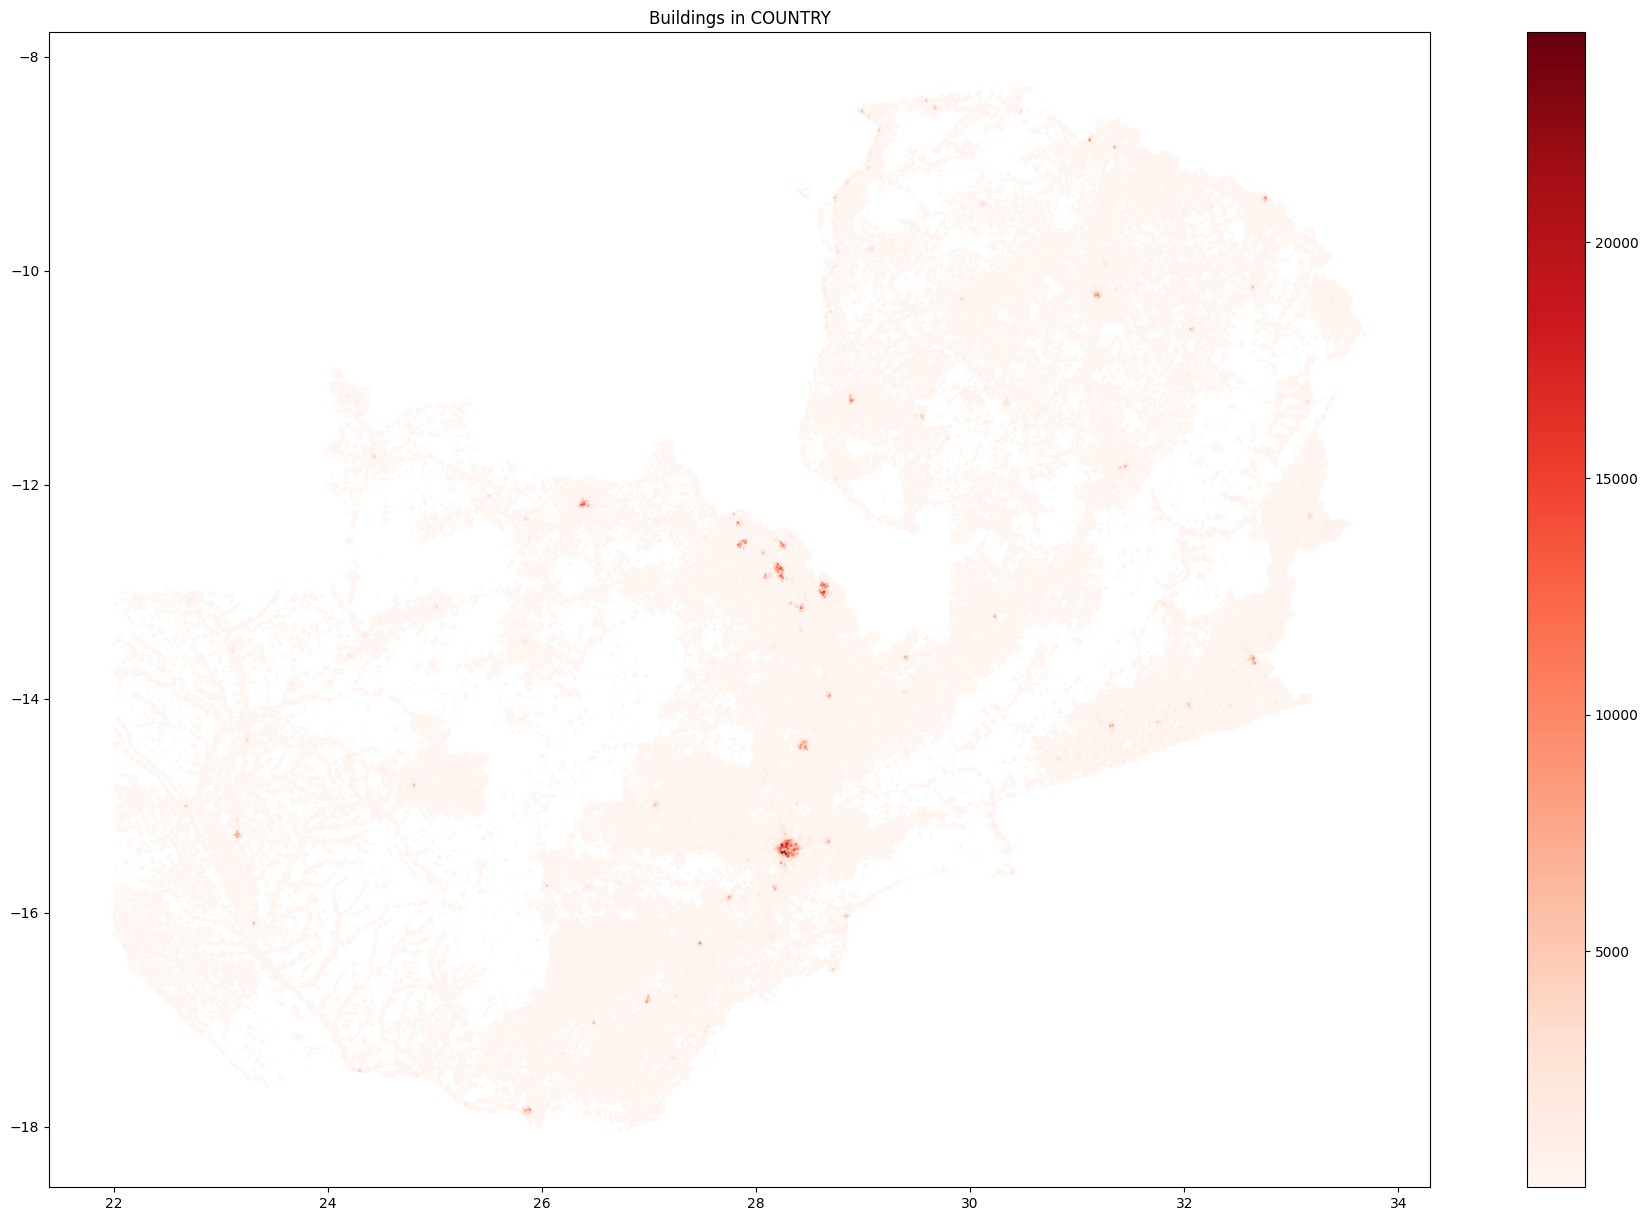

In [25]:
# Plot the buildings map
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('buildingssum', ascending=True).plot(
    ax=ax, column='buildingssum', cmap="Reds", legend=True, alpha=0.9)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Buildings in {}'.format(area) )

# # Save plot as figure 
# plt.savefig('sample_priority_map.png', bbox_inches='tight')

Determine electrifed status of each cell

In [26]:
# electrified or non-electrified status
grid["Status_electrified"] = grid.apply(lambda row: ("elec" if ((row[probElec] > 0.25))
                                             else "nonelec"), axis=1)
grid["Status_electrified"].value_counts()

Status_electrified
nonelec    109649
elec        13339
Name: count, dtype: int64

Determine location (ruban or rural) of each cell

In [27]:
# for each hexagon, determine if it's rural or urban --> choose best source
# grid["locAssessed"] = grid.apply(lambda row: ("urban" if ((row['buildingssum'] > 1000)) # number chosen to get 1 for nb of HH per rural building
#                                              else "rural"), axis=1)
grid["locWorldPop"] = grid.apply(lambda row: ("urban" if ((row['locationWP'] == 1)) 
                                             else "rural"), axis=1)
# grid["locGHSL"] = grid.apply (lambda row: ("urban" if ((row['SMOD'] == 30) or (row['SMOD'] == 21) or (row['SMOD'] == 22) or (row['SMOD' ] == 23)) 
#                                              else "rural"), axis=1)
grid["location"] = grid["locWorldPop"] 

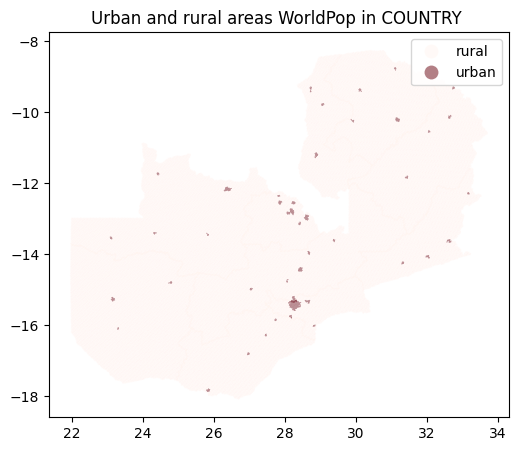

In [28]:
# map of the urban and rural areas WorldPop
# Create the axis first
fig2, ax2 = plt.subplots(figsize=(10, 5))
# Plot
grid.sort_values('locWorldPop', ascending=True).plot(
    ax=ax2, column='locWorldPop', cmap="Reds", legend=True, alpha=0.5)

ax2.set_aspect('equal', 'box')
txt = ax2.set_title('Urban and rural areas WorldPop in {} '.format(area))

Assess number of residential households per cell

In [29]:
# Load data into Pandas DataFrame
## Census data
data_path = "Residential/Data/"
census_name = 'Census_Zambia.csv'
df_censusdata = pd.read_csv(data_path + census_name)

# Create a new dataframe that will contain the regional data
data_HH = df_censusdata[['Region', 'Urban', 'Rural']]
data_HH = data_HH.rename({'Region':'region','Urban':'HH_urban', 'Rural':'HH_rural'}, axis = 1)
data_HH = data_HH.set_index(['region'])
data_HH['HH_total'] = data_HH['HH_urban'] + data_HH['HH_rural']
data_HH = data_HH.astype(float)

In [30]:
# Option 1: use buildings count from Worldpop to assess number of buildings
# total number of buildings
data_buildings = []
for region in regions:
    totalBuildings = grid[(grid['NAME_1'] == region)]['buildingssum'].sum()
    urbanBuildings = grid[(grid['location'] == "urban") & (grid['NAME_1'] == region)]['buildingssum'].sum()
    ruralBuildings = grid[(grid['location'] == "rural") & (grid['NAME_1'] == region)]['buildingssum'].sum()
    data_region = {
        'region': region,
        'totalBuildings': totalBuildings,
        'urbanBuildings': urbanBuildings,
        'ruralBuildings': ruralBuildings,
        'shareRuralBuild': ruralBuildings / totalBuildings,
        'shareUrbanBuild': urbanBuildings / totalBuildings,
    }
    data_buildings.append(data_region)
    # print("total Buildings in",f"{region}",f"{totalBuildings:,.0f}", "urban:",f"{urbanBuildings:,.0f}", "rural:",f"{ruralBuildings:,.0f}")
    # print("share Build urban:", f"{data_region['shareUrbanBuild']:.0%}","rural:",f"{data_region['shareRuralBuild']:.0%}")

df_buildings = pd.DataFrame(data_buildings)
df_buildings = df_buildings.set_index('region')
# df_buildings
df_HH_buildings = data_HH.merge(df_buildings, left_on='region', right_on='region')
df_HH_buildings

,HH_urban,HH_rural,HH_total,totalBuildings,urbanBuildings,ruralBuildings,shareRuralBuild,shareUrbanBuild
region,,,,,,,,
Copperbelt,"449,077.00","85,356.00","534,433.00","1,117,170.00","604,165.00","513,005.00",0.46,0.54
Muchinga,"24,953.00","151,730.00","176,683.00","623,493.00","80,335.00","543,158.00",0.87,0.13
North-Western,"91,501.00","116,233.00","207,734.00","576,163.00","151,021.00","425,142.00",0.74,0.26
Western,"54,466.00","205,604.00","260,070.00","796,764.00","80,858.00","715,906.00",0.90,0.10
Luapula,"44,689.00","228,300.00","272,989.00","615,968.00","84,579.00","531,389.00",0.86,0.14
Northern,"72,867.00","230,684.00","303,551.00","823,956.00","104,365.00","719,591.00",0.87,0.13
Central,"98,493.00","292,947.00","391,440.00","1,533,577.00","321,668.00","1,211,909.00",0.79,0.21
Southern,"120,410.00","316,294.00","436,704.00","1,359,567.00","132,997.00","1,226,570.00",0.90,0.10
Eastern,"82,166.00","369,725.00","451,891.00","1,359,153.00","119,052.00","1,240,101.00",0.91,0.09


Assess number of residential buildings

In [31]:
# share of residential building in each location --> not used because we use the assumption of nb of HH per res bui but can be used if we have data on share of residential building
# shareResBuildings = {"urban": 0.5, "rural": 0.15} # --> to change! # number chosen to get 1 for nb of HH per rural building, and for urban twice the value in rural
# df_HH_buildings['resUrbanBui'] = df_HH_buildings['urbanBuildings'] * shareResBuildings["urban"]
# df_HH_buildings['resRuralBui'] = df_HH_buildings['ruralBuildings'] * shareResBuildings["rural"]
# df_HH_buildings['resTotalBui'] = df_HH_buildings['resUrbanBui'] + df_HH_buildings['resRuralBui']

# Assess the number of residential HH per building
nbOfHHperResBuilding =  {"urban": 1.1, "rural": 1}  # --> to update depending on the country
# nbOfHHperResBuilding["urban"]= HH_urban/resUrbanBuildings --> use if the main assumption is on the share of res buildings
# nbOfHHperResBuilding["rural"]= HH_rural/resRuralBuildings --> use if the main assumption is on the share of res buildings

# Assess the number of residential buildings
df_HH_buildings['shareUrbanResBui'] = df_HH_buildings['HH_urban'] /(nbOfHHperResBuilding["urban"]* df_HH_buildings['urbanBuildings'])
df_HH_buildings['shareRuralResBui'] = df_HH_buildings['HH_rural'] /(nbOfHHperResBuilding["rural"]* df_HH_buildings['ruralBuildings'])
df_HH_buildings['resUrbanBui'] = df_HH_buildings['urbanBuildings'] * df_HH_buildings['shareUrbanResBui']
df_HH_buildings['resRuralBui'] = df_HH_buildings['ruralBuildings'] * df_HH_buildings['shareRuralResBui']
df_HH_buildings['resTotalBui'] = df_HH_buildings['resUrbanBui'] + df_HH_buildings['resRuralBui']

# Check: Assess the total number of HH in the region (should match the census data)
totalResHHurban = nbOfHHperResBuilding["urban"]*df_HH_buildings['resUrbanBui']
# print(totalResHHurban)
# print(df_HH_buildings['HH_urban'])
# assert totalResHHurban.equals(df_HH_buildings['HH_urban'])
totalResHHrural = nbOfHHperResBuilding["rural"]*df_HH_buildings['resRuralBui']
# assert totalResHHrural.equals(df_HH_buildings['HH_rural'])

# Number of HH per res buildings in each region average
df_HH_buildings['nbOfHHperResBui_average'] = df_HH_buildings['HH_total'] / (df_HH_buildings['urbanBuildings']*df_HH_buildings['shareUrbanResBui'] +
                                                                 df_HH_buildings['ruralBuildings'] * df_HH_buildings['shareRuralResBui'])

# df_HH_buildings

In [32]:
# Assess the number of HH per cell
grid['res_urbanBui'] = grid['buildingssum'] * (grid['location'] == 'urban') * grid['NAME_1'].map(df_HH_buildings['shareUrbanResBui'])
grid['res_ruralBui'] = grid['buildingssum'] * (grid['location'] == 'rural') * grid['NAME_1'].map(df_HH_buildings['shareRuralResBui'])
grid['res_Bui'] = grid['res_urbanBui'] + grid['res_ruralBui']
grid['HH_urban'] = grid['res_urbanBui'] * nbOfHHperResBuilding['urban']
grid['HH_rural'] = grid['res_ruralBui'] * nbOfHHperResBuilding['rural']
grid['HH_total'] = grid['HH_rural'] + grid['HH_urban']

In [33]:
# Population per cell
df_censusdata = df_censusdata.set_index('Region')
# df_censusdata

In [34]:
# in each cell compute the population size = HH * HH size
get_size_HH = lambda row: df_censusdata.loc[row['NAME_1'], 'size_HH_' + row['location']]
grid['population'] = (
    grid['HH_total'] *
    grid.apply(get_size_HH, axis=1)
    )
total_population = grid['population'].sum()
print(f"Total population: {total_population:,.0f}")
grid['population_urban'] = (
    grid['HH_urban'] *
    grid.apply(get_size_HH, axis=1)
    )
grid['population_rural'] = (
    grid['HH_rural'] *
    grid.apply(get_size_HH, axis=1)
    )

Total population: 17,798,700


Assess number of residential households per cell with access to electricity

In [35]:
# for each hexagon, assessment of the number of HH with access
# access_elec = {"elec": 0, "nonelec": 1}
grid["HHwithAccess_urb"] = grid['HH_urban'] * grid[probElec] * (grid["Status_electrified"]=='elec')
grid["HHwithAccess_rur"] = grid['HH_rural'] * grid[probElec] * (grid["Status_electrified"]=='elec')                                      
grid["HHwithAccess"] = grid["HHwithAccess_urb"] + grid["HHwithAccess_rur"]

grid['HHwoAccess_urb'] = grid['HH_urban'] - grid['HHwithAccess_urb']
grid['HHwoAccess_rur'] = grid['HH_rural'] - grid['HHwithAccess_rur']
grid['HHwoAccess'] = grid['HHwoAccess_urb'] + grid['HHwoAccess_rur']

totalHHWithAccessUrb = grid.groupby('NAME_1')['HHwithAccess_urb'].sum()
totalHHWithAccessRur = grid.groupby('NAME_1')['HHwithAccess_rur'].sum()
totalHHWithAccess = grid.groupby('NAME_1')['HHwithAccess'].sum()

df_HH_access = pd.concat([totalHHWithAccessUrb, totalHHWithAccessRur, totalHHWithAccess], axis=1)
df_HH_access.rename_axis('region', inplace=True)
df_HH_buildings = df_HH_buildings.merge(df_HH_access, left_on='region', right_on='region')
df_HH_buildings


,HH_urban,HH_rural,HH_total,totalBuildings,urbanBuildings,ruralBuildings,shareRuralBuild,shareUrbanBuild,shareUrbanResBui,shareRuralResBui,resUrbanBui,resRuralBui,resTotalBui,nbOfHHperResBui_average,HHwithAccess_urb,HHwithAccess_rur,HHwithAccess
region,,,,,,,,,,,,,,,,,
Copperbelt,"449,077.00","85,356.00","534,433.00","1,117,170.00","604,165.00","513,005.00",0.46,0.54,0.68,0.17,"408,251.82","85,356.00","493,607.82",1.08,"449,039.15","45,052.11","494,091.26"
Muchinga,"24,953.00","151,730.00","176,683.00","623,493.00","80,335.00","543,158.00",0.87,0.13,0.28,0.28,"22,684.55","151,730.00","174,414.55",1.01,"24,072.70","16,379.90","40,452.60"
North-Western,"91,501.00","116,233.00","207,734.00","576,163.00","151,021.00","425,142.00",0.74,0.26,0.55,0.27,"83,182.73","116,233.00","199,415.73",1.04,"85,636.39","21,626.72","107,263.11"
Western,"54,466.00","205,604.00","260,070.00","796,764.00","80,858.00","715,906.00",0.90,0.10,0.61,0.29,"49,514.55","205,604.00","255,118.55",1.02,"52,836.57","24,522.04","77,358.61"
Luapula,"44,689.00","228,300.00","272,989.00","615,968.00","84,579.00","531,389.00",0.86,0.14,0.48,0.43,"40,626.36","228,300.00","268,926.36",1.02,"42,539.42","67,694.76","110,234.17"
Northern,"72,867.00","230,684.00","303,551.00","823,956.00","104,365.00","719,591.00",0.87,0.13,0.63,0.32,"66,242.73","230,684.00","296,926.73",1.02,"69,696.85","33,319.39","103,016.23"
Central,"98,493.00","292,947.00","391,440.00","1,533,577.00","321,668.00","1,211,909.00",0.79,0.21,0.28,0.24,"89,539.09","292,947.00","382,486.09",1.02,"97,553.30","52,233.20","149,786.50"
Southern,"120,410.00","316,294.00","436,704.00","1,359,567.00","132,997.00","1,226,570.00",0.90,0.10,0.82,0.26,"109,463.64","316,294.00","425,757.64",1.03,"120,120.16","50,063.85","170,184.01"
Eastern,"82,166.00","369,725.00","451,891.00","1,359,153.00","119,052.00","1,240,101.00",0.91,0.09,0.63,0.30,"74,696.36","369,725.00","444,421.36",1.02,"79,686.10","38,701.44","118,387.55"


In [36]:
df_sum = df_HH_buildings.sum(axis=0)  # Sum across rows
df_sum.name = 'National'  # Set a name for the new row (optional)
df_HH_buildings = pd.concat([df_HH_buildings, df_sum.to_frame().T]) # concatenate the sum Series as a new row
df_HH_buildings

,HH_urban,HH_rural,HH_total,totalBuildings,urbanBuildings,ruralBuildings,shareRuralBuild,shareUrbanBuild,shareUrbanResBui,shareRuralResBui,resUrbanBui,resRuralBui,resTotalBui,nbOfHHperResBui_average,HHwithAccess_urb,HHwithAccess_rur,HHwithAccess
Copperbelt,"449,077.00","85,356.00","534,433.00","1,117,170.00","604,165.00","513,005.00",0.46,0.54,0.68,0.17,"408,251.82","85,356.00","493,607.82",1.08,"449,039.15","45,052.11","494,091.26"
Muchinga,"24,953.00","151,730.00","176,683.00","623,493.00","80,335.00","543,158.00",0.87,0.13,0.28,0.28,"22,684.55","151,730.00","174,414.55",1.01,"24,072.70","16,379.90","40,452.60"
North-Western,"91,501.00","116,233.00","207,734.00","576,163.00","151,021.00","425,142.00",0.74,0.26,0.55,0.27,"83,182.73","116,233.00","199,415.73",1.04,"85,636.39","21,626.72","107,263.11"
Western,"54,466.00","205,604.00","260,070.00","796,764.00","80,858.00","715,906.00",0.90,0.10,0.61,0.29,"49,514.55","205,604.00","255,118.55",1.02,"52,836.57","24,522.04","77,358.61"
Luapula,"44,689.00","228,300.00","272,989.00","615,968.00","84,579.00","531,389.00",0.86,0.14,0.48,0.43,"40,626.36","228,300.00","268,926.36",1.02,"42,539.42","67,694.76","110,234.17"
Northern,"72,867.00","230,684.00","303,551.00","823,956.00","104,365.00","719,591.00",0.87,0.13,0.63,0.32,"66,242.73","230,684.00","296,926.73",1.02,"69,696.85","33,319.39","103,016.23"
Central,"98,493.00","292,947.00","391,440.00","1,533,577.00","321,668.00","1,211,909.00",0.79,0.21,0.28,0.24,"89,539.09","292,947.00","382,486.09",1.02,"97,553.30","52,233.20","149,786.50"
Southern,"120,410.00","316,294.00","436,704.00","1,359,567.00","132,997.00","1,226,570.00",0.90,0.10,0.82,0.26,"109,463.64","316,294.00","425,757.64",1.03,"120,120.16","50,063.85","170,184.01"
Eastern,"82,166.00","369,725.00","451,891.00","1,359,153.00","119,052.00","1,240,101.00",0.91,0.09,0.63,0.30,"74,696.36","369,725.00","444,421.36",1.02,"79,686.10","38,701.44","118,387.55"
Lusaka,"523,768.00","108,025.00","631,793.00","1,156,294.00","747,954.00","408,340.00",0.35,0.65,0.64,0.26,"476,152.73","108,025.00","584,177.73",1.08,"522,714.52","45,435.84","568,150.36"


Compute the resulting access rate

In [37]:
# access rate for HH
df_HH_buildings['accessRateHH'] = df_HH_buildings['HHwithAccess']/df_HH_buildings['HH_total']
df_HH_buildings['accessRateHH_urban'] = df_HH_buildings['HHwithAccess_urb']/df_HH_buildings['HH_urban']
df_HH_buildings['accessRateHH_rural'] = df_HH_buildings['HHwithAccess_rur']/df_HH_buildings['HH_rural']

# access rate for population
# accessRatePop = (totalHHWithAccessUrb*pplperHH_urban+totalHHWithAccessRur*pplperHH_rural)/totalPopStats
# accessRatePop_urban = totalHHWithAccessUrb*pplperHH_urban/totalPop_urban
# accessRatePop_rural = totalHHWithAccessRur*pplperHH_rural/totalPop_rural
# print("Pop access rate :",f"{accessRatePop:,.0%}")
# print("Pop access rate urban:",f"{accessRatePop_urban:,.0%}")
# print("Pop access rate rural:",f"{accessRatePop_rural:,.0%}")

df_HH_buildings.to_csv("dataHH_region.csv")
df_HH_buildings[['accessRateHH','accessRateHH_urban','accessRateHH_rural']]

,accessRateHH,accessRateHH_urban,accessRateHH_rural
Copperbelt,0.92,1.00,0.53
Muchinga,0.23,0.96,0.11
North-Western,0.52,0.94,0.19
Western,0.30,0.97,0.12
Luapula,0.40,0.95,0.30
Northern,0.34,0.96,0.14
Central,0.38,0.99,0.18
Southern,0.39,1.00,0.16
Eastern,0.26,0.97,0.10
Lusaka,0.90,1.00,0.42


### Step 2: assess the energy consumption per HH

#### Method 1: create an index based on rwi and HREA

In [38]:
# # Retrieve values from the MTF survey # not used because it leads to an overassessment of energy
# %run Residential/energy_demand_res.ipynb
# energyConsHH = energycons_res_mtf["annual"] # dictionnary for each region one value
# energyConsHH['COPPERBELT']=1250
# energyConsHH

In [39]:
# function for allocate tier of energy consumption to an index
def index_to_energy(index, table_index):
    energy = 0
    for key, val in table_index:
        if index < key:
            break
        else: energy = val
    return energy

# data for energy consumption tiers
file_HHenergycons = "HH_energyconsumption.csv"
HHenergycons = pd.read_csv(data_path + file_HHenergycons)
thresholds_energy = HHenergycons.iloc[0].tolist() # thresholds_energy  = [5, 73, 365, 1250, 3012]
print(HHenergycons)

   Tier 1  Tier 2  Tier 3  Tier 4  Tier 5
0       8     200     778    2224    4656


##### Index only based on rwi

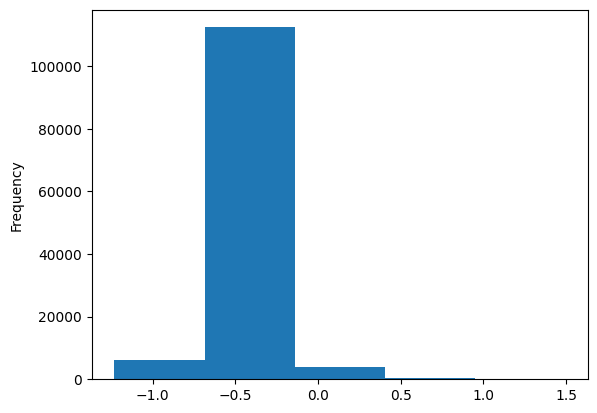

[(-1.2319999933242798, 8), (-0.6863499879837036, 200), (-0.14069998264312744, 778), (0.40495002269744873, 2224), (0.9506000280380249, 4656)]


In [40]:
# Method 1.1: allocate directly rwi to energy consumption
grid['rwi'].plot.hist(bins=5)
plt.show()
thresholds_rwi = (grid['rwi'].max()-grid['rwi'].min())/5*np.arange(5)+grid['rwi'].min()
table_rwi = list(zip(thresholds_rwi, thresholds_energy))
print(table_rwi)
grid['ResEnergyPerHH_rwi'] = grid['rwi'].apply(lambda rwi: index_to_energy(rwi,table_rwi))

Index only based on rwi and HREA

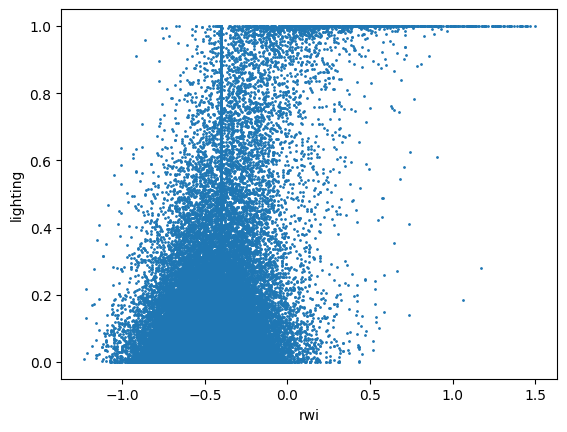

In [41]:
# Link between rwi and HREA
plt.scatter(grid['rwi'], grid['HREA'],s=1)

# Add labels to the plot
plt.xlabel('rwi')
plt.ylabel('lighting')

# Set the axis to logarithmic scale
# plt.yscale('log')
# plt.xscale('log')

# Show the plot
plt.show()

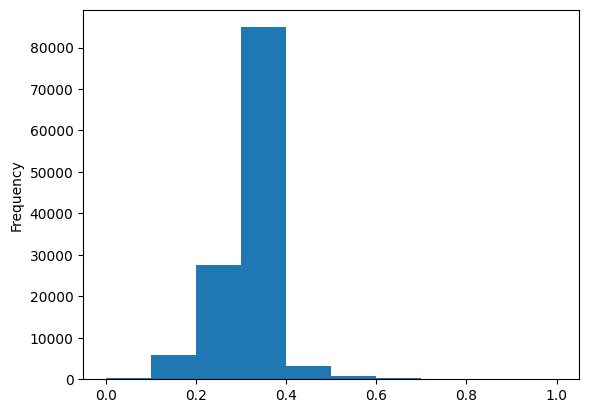

In [42]:
# Normalise the rwi index
rwi_min = grid['rwi'].min()
rwi_max = grid['rwi'].max()
grid['rwi_norm'] = (grid['rwi'] - rwi_min) / (rwi_max - rwi_min)
grid['rwi_norm'].plot.hist()
plt.show()

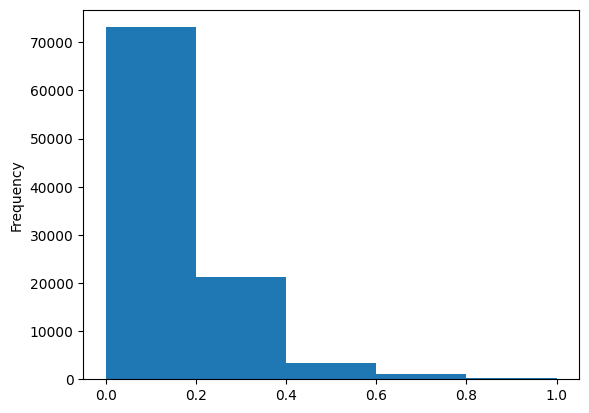

In [43]:
# Method 1.2: create an index combining rwi and HREA: geometric mean 
grid['index'] = np.power(grid['rwi_norm'] * grid['HREA'], 0.5)
grid['index'].plot.hist(bins=5)
thresholds_index = (grid['index'].max()-grid['index'].min())/5*np.arange(5)+grid['index'].min()
table_index = list(zip(thresholds_index, thresholds_energy))
plt.show()

ResEnergyPerHH_index
8       73106
4656    24006
200     21287
778      3411
2224     1178
Name: count, dtype: int64


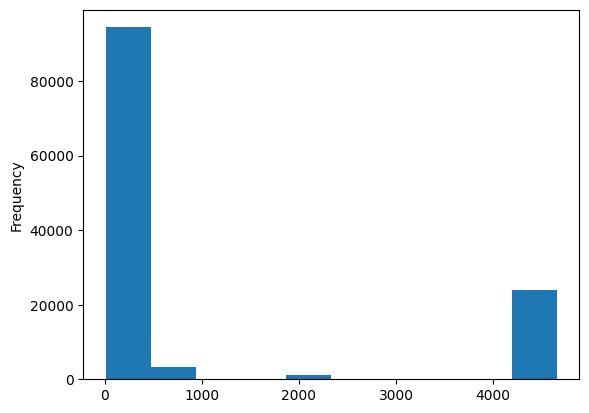

In [44]:
# allocate the energy consumption tier to the index
grid['ResEnergyPerHH_index'] = grid['index'].apply(lambda index: index_to_energy(index,table_index))
grid['ResEnergyPerHH_index'].plot.hist()
print(grid['ResEnergyPerHH_index'].value_counts())
plt.show()

In [45]:
# Assess the shares of tier
tier_share = grid.groupby('ResEnergyPerHH_index')['HHwithAccess'].sum()
tier_share.loc[0] = grid['HHwoAccess'].sum()
# print(tier_share)
print(tier_share/tier_share.sum())
# urban shares
tier_urban_share = grid.groupby('ResEnergyPerHH_index')['HHwithAccess_urb'].sum()
tier_urban_share.loc[0] = grid['HHwoAccess_urb'].sum()
print(tier_urban_share/tier_urban_share.sum())
# rural shares
tier_rural_share = grid.groupby('ResEnergyPerHH_index')['HHwithAccess_rur'].sum() 
tier_rural_share.loc[0] = grid['HHwoAccess_rur'].sum()
print(tier_rural_share/tier_rural_share.sum())

ResEnergyPerHH_index
8      0.00
200    0.02
778    0.05
2224   0.16
4656   0.29
0      0.47
Name: HHwithAccess, dtype: float64
ResEnergyPerHH_index
8      0.00
200    0.00
778    0.02
2224   0.29
4656   0.68
0      0.01
Name: HHwithAccess_urb, dtype: float64
ResEnergyPerHH_index
8      0.00
200    0.04
778    0.07
2224   0.07
4656   0.01
0      0.81
Name: HHwithAccess_rur, dtype: float64


#### Method 2: link the energy consumption with rwi through a logistic function

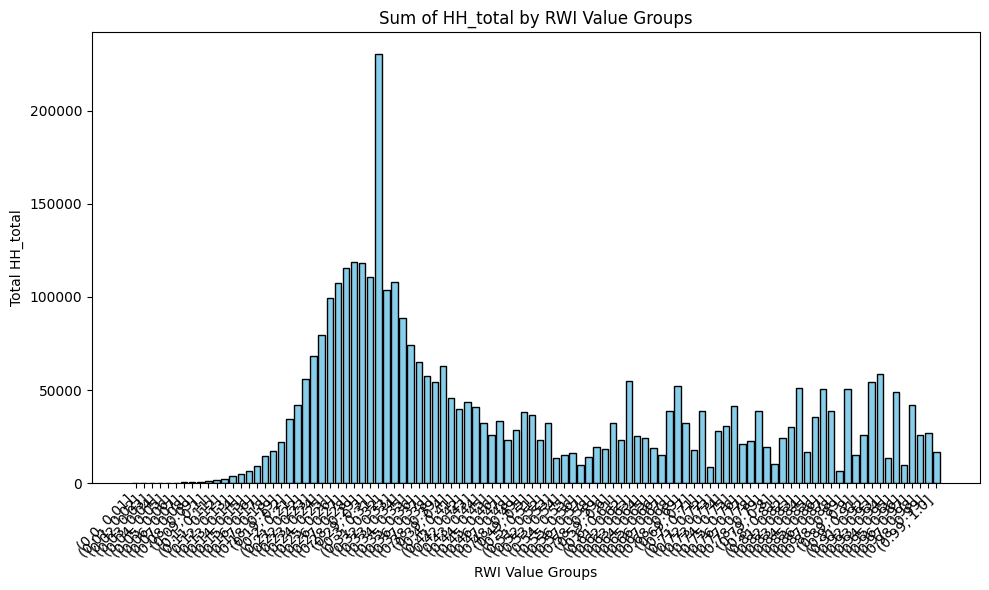

In [46]:
# Plot of number of HH vs rwi

# Create equally spaced bins for the 'rwi' values
num_groups = 100
min_rwi = grid['rwi_norm'].min()
max_rwi = grid['rwi_norm'].max()
bin_width = (max_rwi - min_rwi) / num_groups
bins = [min_rwi + i * bin_width for i in range(num_groups + 1)]

# Group by the bins and sum the 'HH_total' values
grid['rwi_group'] = pd.cut(grid['rwi_norm'], bins)
result = grid.groupby('rwi_group')['HH_total'].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH_total')
plt.title('Sum of HH_total by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

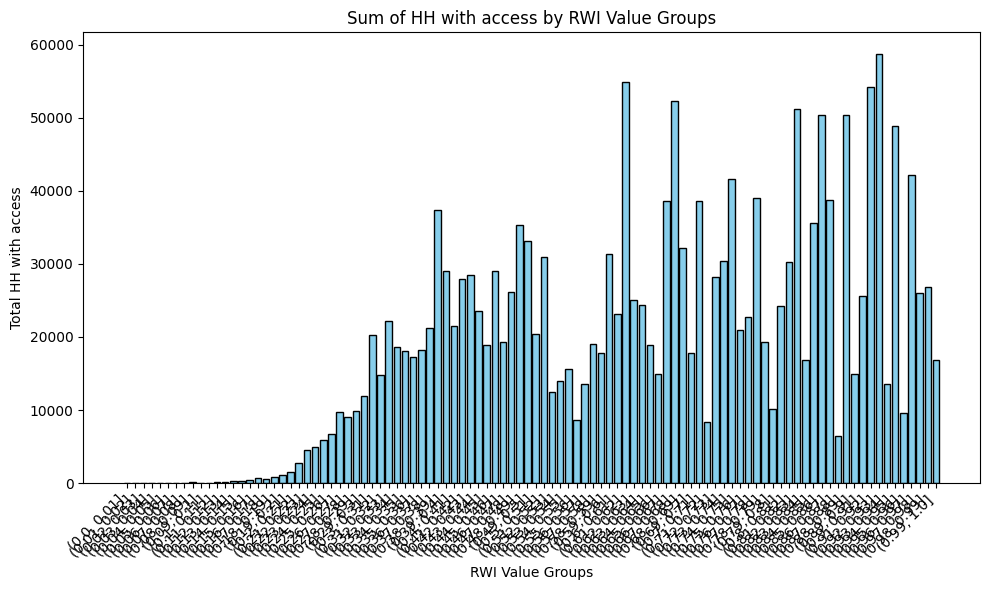

In [47]:
# Plot of number of HH with access vs rwi

# Group by the bins and sum the 'HHwithAccess' values
result = grid.groupby('rwi_group')['HHwithAccess'].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH with access')
plt.title('Sum of HH with access by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [48]:
# solve the equation so that the energy consumption per HH matches total energy demand
from scipy.optimize import fsolve

# variable for the relatioship between rwi and E
E_threshold = 3400
alpha = E_threshold / 4.5 - 1  # alpha set so that E_HH = 4.5 kWh for the lowest tier

def func(x):
    e_hh = E_threshold / (1 + alpha * np.exp(-x  * grid['rwi_norm']))
    res_energy_assessed = e_hh * grid ['HHwithAccess']
    return res_energy_assessed.sum()/10**6- total_residentialenergy_GWh

# Use scipy to solve the equation to find k
k_initial_guess = 2
k_solution = fsolve(func, k_initial_guess)
print(k_solution)


[11.29385159]


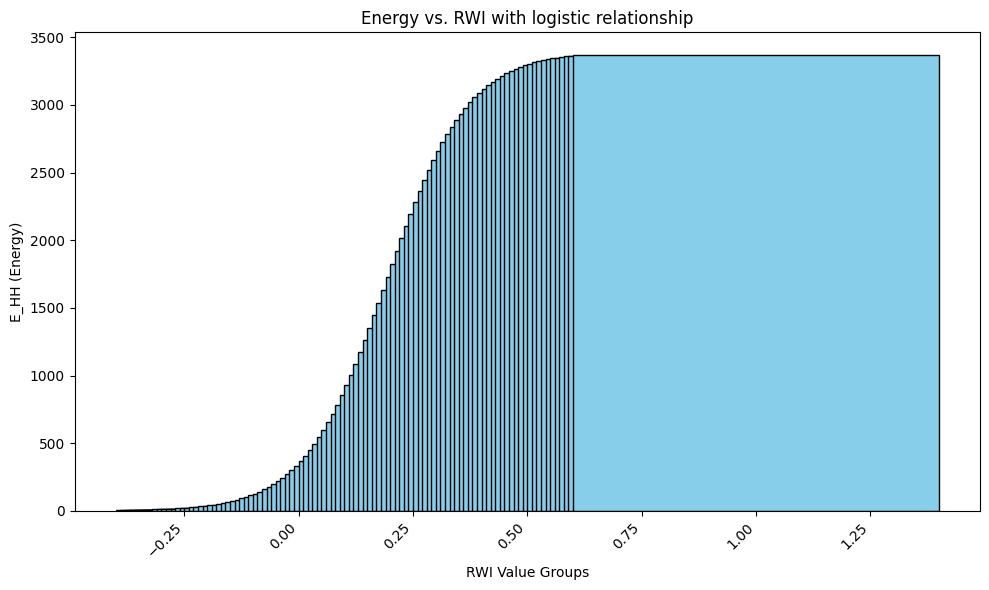

In [49]:
# create the curve linking energy consumption per HH and rwi
rwi_values = bins # Your rwi value groups
# E_threshold = 3100
# alpha = E_threshold / 4.5 - 1  # alpha set so that E_HH = 4.5 kWh for the lowest tier
k = k_solution  # Adjust this constant for the desired curve steepness
E_HH_values = E_threshold / (1 + alpha * np.exp(-k * np.array(rwi_values)))
# print(E_threshold / (1 + alpha * np.exp(-k  * 0)))
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(rwi_values, E_HH_values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('E_HH (Energy)')
plt.title('Energy vs. RWI with logistic relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

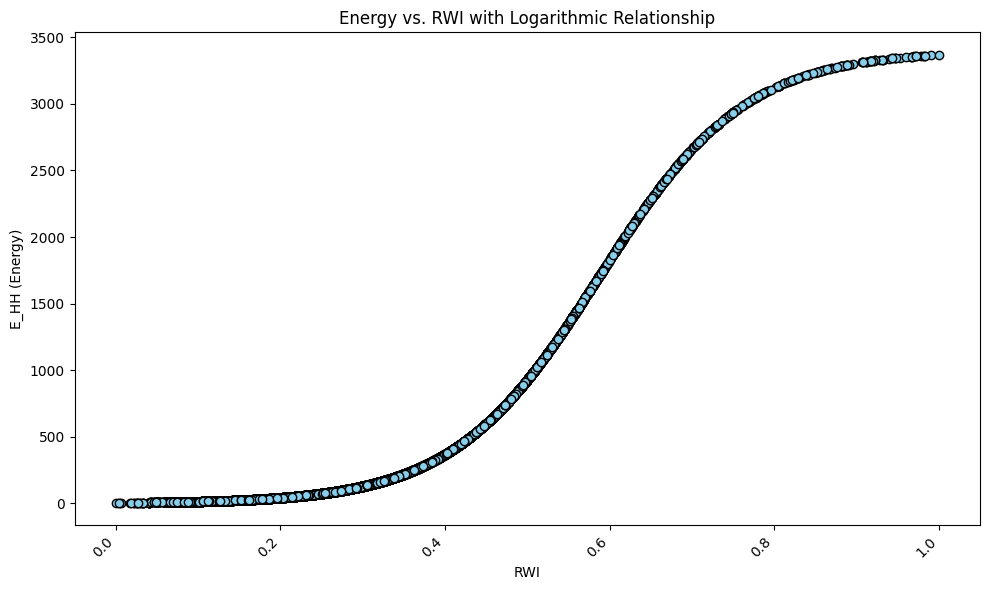

In [50]:
# check that total energy assessed matches the statistics
grid['ResEnergyPerHH_log'] = E_threshold / (1 + alpha * np.exp(-k * grid['rwi_norm']))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.scatter(grid['rwi_norm'], grid['ResEnergyPerHH_log'], color='skyblue', edgecolor='black')
plt.xlabel('RWI')
plt.ylabel('E_HH (Energy)')
plt.title('Energy vs. RWI with Logarithmic Relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [51]:
# Assess the tier shares 

# Create bins
bins = [0, 5, 72.9, 364.9, 1250.4, 3012.2]
labels = ['1', '2', '3', '4', '5']

# Add a new column with bin labels
grid['bin_labels'] = pd.cut(grid['ResEnergyPerHH_log'], bins=bins, labels=labels)

tier_share = grid.groupby('bin_labels')['HHwithAccess'].sum()
tier_share.loc[0] = grid['HHwoAccess'].sum()
# print(tier_share)
print(tier_share/tier_share.sum())
# urban shares
tier_urban_share = grid.groupby('bin_labels')['HHwithAccess_urb'].sum()
tier_urban_share.loc[0] = grid['HHwoAccess_urb'].sum()
print(tier_urban_share/tier_urban_share.sum())
# rural shares
tier_rural_share = grid.groupby('bin_labels')['HHwithAccess_rur'].sum() 
tier_rural_share.loc[0] = grid['HHwoAccess_rur'].sum()
print(tier_rural_share/tier_rural_share.sum())

bin_labels
1   0.00
2   0.01
3   0.09
4   0.12
5   0.20
0   0.59
Name: HHwithAccess, dtype: float64
bin_labels
1   0.00
2   0.00
3   0.08
4   0.25
5   0.65
0   0.02
Name: HHwithAccess_urb, dtype: float64
bin_labels
1   0.00
2   0.01
3   0.09
4   0.06
5   0.02
0   0.81
Name: HHwithAccess_rur, dtype: float64


#### Method 3: use data coming from the DHS survey

In [52]:
# load data file --> to transform into calling the related script
dataDHS_file = 'dataDHS_group.csv'
data_path = 'Residential/Data/DHSSurvey/'
dataDHS = pd.read_csv(data_path + dataDHS_file)

# interpolation of data results in kWh
for loc in ['urban', 'rural']:
    column_name = 'HHwithAccess_' + loc[:3]
    include = (grid[column_name]>0)
    rwi_group = dataDHS['rwi_group_' + loc]
    eu_group = dataDHS['eu_group_' + loc]
    grid.loc[include, 'ResEnergyPerHH_DHS'] = np.interp(grid['rwi'][include],rwi_group,eu_group) * (grid["Status_electrified"][include]=='elec')

### Comparison access rates, to Falchetta dataset

In [53]:
tier_total = grid.groupby('tiers')[['HH_total', 'HH_urban', 'HH_rural']].sum()
df_falchetta_data = tier_total / tier_total.sum()
df_falchetta_data

,HH_total,HH_urban,HH_rural
tiers,,,
0.00,0.57,0.06,0.95
1.00,0.00,0.00,0.00
2.00,0.01,0.01,0.01
3.00,0.01,0.01,0.01
4.00,0.41,0.92,0.04


In [54]:
# for meth 3 derive number per tier
bins_tiers = [0, 5, 72.9, 364.9, 1250.4, 3012.2, np.inf]
grid['tiers_DHS'] = pd.cut(grid['ResEnergyPerHH_DHS'], bins_tiers, labels=range(len(bins_tiers)-1))

# Add the "0" category if it's not already present
# grid['tiers_DHS'] = pd.Categorical(grid['tiers_DHS']).add_categories("0")
# Fill NaN values with "0"
grid['tiers_DHS'] = grid['tiers_DHS'].fillna(0)

# grid[['tiers_DHS', 'ResEnergyPerHH_DHS']]
# grid['ResEnergyPerHH_DHS']
tier_share = grid.groupby('tiers_DHS')['HH_total'].sum()
df_tiers_data_national = tier_share/tier_share.sum()
# urban shares
tier_urban_share = grid.groupby('tiers_DHS')['HH_urban'].sum()
df_tiers_data_urban = tier_urban_share/tier_urban_share.sum()
# rural shares
tier_rural_share = grid.groupby('tiers_DHS')['HH_rural'].sum() 
df_tiers_data_rural = tier_rural_share/tier_rural_share.sum()
df_tiers_data = pd.concat([df_tiers_data_national,df_tiers_data_urban,df_tiers_data_rural], axis=1)
df_tiers_data
# grid['tiers_DHS']

,HH_total,HH_urban,HH_rural
tiers_DHS,,,
0,0.57,0.00,0.98
1,0.01,0.00,0.01
2,0.01,0.02,0.00
3,0.06,0.14,0.00
4,0.14,0.33,0.00
5,0.21,0.50,0.00


In [55]:
# # compute population access rate
# tier_rural_share_pop = (grid.groupby('tiers_DHS')['HH_rural']
#                     .apply(lambda x: x * grid.apply(get_size_HH, axis=1).iloc[x.index]))
# tier_rural_share_pop

tier_pop_national = grid.groupby('tiers_DHS')['population'].sum()
df_tiers_data_pop_national = tier_pop_national/tier_pop_national.sum()

tier_urban_pop = grid.groupby('tiers_DHS')['population_urban'].sum()
df_tiers_data_pop_urban = tier_urban_pop/tier_urban_pop.sum()

tier_rural_pop = grid.groupby('tiers_DHS')['population_rural'].sum()
df_tiers_data_pop_rural = tier_rural_pop/tier_rural_pop.sum()

df_tiers_data_pop = pd.concat([df_tiers_data_pop_national,df_tiers_data_pop_urban,df_tiers_data_pop_rural], axis=1)
df_tiers_data_pop

,population,population_urban,population_rural
tiers_DHS,,,
0,0.59,0.00,0.98
1,0.01,0.00,0.01
2,0.01,0.02,0.00
3,0.06,0.14,0.00
4,0.13,0.34,0.00
5,0.20,0.50,0.00


### Step 3: assess energy consumption per cell

In [56]:
# Assess the energy Consumption assessment per cell
averageRwi = grid['rwi'].mean()
weightedRwi_norm = grid['rwi_norm'] * (grid ['HH_urban'] + grid ['HH_rural'])
averageRwi_norm = weightedRwi_norm.sum()/ (grid ['HH_urban'].sum() + grid ['HH_rural'].sum())
print(averageRwi_norm)

# grid["ResEnergyPerHH"] = abs(grid['rwi']/averageRwi)*grid["ADM1_NAME"].map(energyConsHH)

grid["ResEnergyPerHH_meth11a"] = grid['ResEnergyPerHH_rwi']*abs(grid['rwi']/averageRwi)
grid["ResEnergyPerHH_meth11b"] = grid['ResEnergyPerHH_rwi']
grid["ResEnergyPerHH_meth12a"] = grid['ResEnergyPerHH_index']*abs(grid['rwi_norm']/averageRwi_norm)
grid["ResEnergyPerHH_meth12b"] = grid['ResEnergyPerHH_index']
grid["ResEnergyPerHH_meth2"] = grid['ResEnergyPerHH_log']
grid["ResEnergyPerHH_meth3"] = grid['ResEnergyPerHH_DHS']


0.4861133701527587


In [57]:
methods = ['meth11a', 'meth11b', 'meth12a', 'meth12b', 'meth2', 'meth3']
result_beforescaling = pd.DataFrame()
result_afterscaling = pd.DataFrame()
for method in methods:
    grid["ResEnergy_kWh_" + method] = grid["HHwithAccess"] * grid["ResEnergyPerHH_" + method]
    result_beforescaling[method] = grid.groupby('NAME_1')['ResEnergy_kWh_' + method].sum() / 10**6 # conversion in GWh
    total_residentialenergy_assessed = result_beforescaling[method].sum() #res_energy_assessed 
    scaling_factor = total_residentialenergy_GWh/total_residentialenergy_assessed
    result_afterscaling[method] = result_beforescaling[method] * scaling_factor
result_beforescaling

# result = pd.DataFrame.from_dict(result_beforescaling)

,meth11a,meth11b,meth12a,meth12b,meth2,meth3
NAME_1,,,,,,
Central,597.31,280.37,591.15,409.02,238.97,253.74
Copperbelt,"3,549.21","1,531.05","3,245.77","2,033.14","1,314.81","1,424.93"
Eastern,118.10,106.24,303.39,255.54,131.72,131.62
Luapula,22.19,52.41,150.46,164.99,57.78,38.74
Lusaka,"5,542.13","1,992.23","4,023.46","2,312.90","1,563.57","1,880.75"
Muchinga,16.13,24.23,70.00,68.63,31.60,30.17
North-Western,293.82,181.55,454.17,330.67,190.22,191.32
Northern,145.84,111.60,286.83,236.81,118.02,115.47
Southern,454.96,294.16,673.52,495.59,301.84,283.42


In [58]:
result_beforescaling.sum(axis=0)

meth11a   10,801.54
meth11b    4,641.07
meth12a    9,986.01
meth12b    6,475.26
meth2      4,022.50
meth3      4,422.02
dtype: float64

In [59]:
result_afterscaling

,meth11a,meth11b,meth12a,meth12b,meth2,meth3
NAME_1,,,,,,
Central,222.44,243.00,238.12,254.09,238.97,230.81
Copperbelt,"1,321.73","1,326.99","1,307.44","1,263.01","1,314.81","1,296.20"
Eastern,43.98,92.08,122.21,158.74,131.72,119.72
Luapula,8.26,45.42,60.61,102.50,57.78,35.24
Lusaka,"2,063.89","1,726.70","1,620.70","1,436.80","1,563.57","1,710.83"
Muchinga,6.01,21.00,28.20,42.63,31.60,27.45
North-Western,109.42,157.36,182.94,205.41,190.22,174.03
Northern,54.31,96.72,115.54,147.11,118.02,105.04
Southern,169.43,254.95,271.30,307.86,301.84,257.81


In [60]:
# # assess total residential energy consumption
# total_residentialenergy_assessed = grid["ResEnergy_kWh"].sum()
# print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh
# total_residentialenergy_assessed = total_residentialenergy_assessed/10**6  # conversion in GWh

### Scale residential demand results

Get the electricity consumption at the national level for HH

In [61]:
print("residential electricity consumption UN STATS:", f"{total_residentialenergy_GWh:,.0f}", "GWh")
# print("residential electricity consumption assessed:", f"{total_residentialenergy_assessed:,.0f}", "GWh")

residential electricity consumption UN STATS: 4,022 GWh


Compute total electricity consumption

In [62]:
# total_residentialenergy_beforescaled = grid.groupby('NAME_1')['ResEnergy_kWh'].sum() #res_energy_assessed ResEnergy_kWh
# print ("Residential electricity consumption assessed before scaling:")
# for region in regions:
#     total_residentialenergy_beforescaled[region] = total_residentialenergy_beforescaled[region]/10**6  # conversion in GWh
#     print (region, f"{total_residentialenergy_beforescaled[region]:,.1f}", "GWh" )
# print (total_residentialenergy_beforescaled )

In [63]:
# # Scale previous results if area is country
# scaling_factor = total_residentialenergy/total_residentialenergy_assessed
# grid["ResEnergy_kWh"] = grid['ResEnergyPerHH_DHS']
# if area == "COUNTRY":
#     print('{:.0%}'.format(scaling_factor))
#     grid["REnS_kWh"] = grid["ResEnergy_kWh"] * scaling_factor
# else:
#     grid["REnS_kWh"] = grid["ResEnergy_kWh"]

In [64]:
# total_residentialenergy_scaled = grid.groupby('NAME_1')['REnS_kWh'].sum()   
# print ("Residential electricity consumption assessed after scaling:")
# for region in regions:
#     total_residentialenergy_scaled[region] = total_residentialenergy_scaled[region]/10**6  # conversion in GWh
#     print (region, f"{total_residentialenergy_scaled[region]:,.1f}", "GWh" )
# print (total_residentialenergy_scaled )

In [65]:
print(grid.columns)

Index(['hexagons', 'lon', 'lat', 'index_righ', 'NAME_1', 'id', 'buildingssum',
       'locationWP', 'HREA', 'rwi', 'tiers', 'GDP_PPP', 'geometry',
       'Status_electrified', 'locWorldPop', 'location', 'res_urbanBui',
       'res_ruralBui', 'res_Bui', 'HH_urban', 'HH_rural', 'HH_total',
       'population', 'population_urban', 'population_rural',
       'HHwithAccess_urb', 'HHwithAccess_rur', 'HHwithAccess',
       'HHwoAccess_urb', 'HHwoAccess_rur', 'HHwoAccess', 'ResEnergyPerHH_rwi',
       'rwi_norm', 'index', 'ResEnergyPerHH_index', 'rwi_group',
       'ResEnergyPerHH_log', 'bin_labels', 'ResEnergyPerHH_DHS', 'tiers_DHS',
       'ResEnergyPerHH_meth11a', 'ResEnergyPerHH_meth11b',
       'ResEnergyPerHH_meth12a', 'ResEnergyPerHH_meth12b',
       'ResEnergyPerHH_meth2', 'ResEnergyPerHH_meth3', 'ResEnergy_kWh_meth11a',
       'ResEnergy_kWh_meth11b', 'ResEnergy_kWh_meth12a',
       'ResEnergy_kWh_meth12b', 'ResEnergy_kWh_meth2', 'ResEnergy_kWh_meth3'],
      dtype='object')


In [66]:
grid.to_csv("data.csv")
grid = grid.drop('rwi_group', axis=1)
grid = grid.drop('tiers_DHS', axis=1)
if 'bin_labels' in grid.columns:
    grid = grid.drop('bin_labels', axis=1)
grid.to_file(out_path + "\\" + 'res_energy_map.shp', index=False)
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,...,ResEnergyPerHH_meth12a,ResEnergyPerHH_meth12b,ResEnergyPerHH_meth2,ResEnergyPerHH_meth3,ResEnergy_kWh_meth11a,ResEnergy_kWh_meth11b,ResEnergy_kWh_meth12a,ResEnergy_kWh_meth12b,ResEnergy_kWh_meth2,ResEnergy_kWh_meth3
0,87399485cffffff,30.52,-12.18,5.00,Muchinga,1,57.00,0.00,0.03,-0.81,...,2.56,8,25.97,NaN,0.00,0.00,0.00,0.00,0.00,NaN
1,873995215ffffff,30.42,-10.43,7.00,Northern,2,NaN,NaN,NaN,-0.40,...,"2,920.89",4656,135.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,87344b340ffffff,25.31,-16.22,8.00,Southern,3,NaN,NaN,0.09,-0.40,...,5.02,8,135.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Compare results per method for each method

# Services

## Get the electricity consumption for services

In [67]:
# energyBalance_path = "EnergyBalance/"
# file_energyBalance = "UNSD+DF_UNData_EnergyBalance+1.0_Zambia.csv"
# eb = pd.read_csv(energyBalance_path + file_energyBalance)
# code_elec = "B07_EL"
code_ser =  "B49_1235"
cod_oth = "B51_1234" # Other consumption not elsewhere specified in UN stats
total_servicesenergy = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_ser) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
total_servicesenergy = pd.to_numeric(total_servicesenergy.str.replace(',', '')) # convert to numeric and remove commas
total_servicesenergy_GWh = total_servicesenergy.iloc[0]/3.6 # conversion in GWh
print("services electricity consumption UN STATS:", f"{total_servicesenergy_GWh:,.0f}", "GWh")

services electricity consumption UN STATS: 722 GWh


## Energy consumption based on number of buildings with access

In [68]:
# services building in each location
grid['serBui'] = grid['buildingssum'] - grid['res_Bui']
totalSerBui = grid['serBui'].sum()
totalSerBui
print(f"{totalSerBui:,.0f}", "services buildings")

6,436,852 services buildings


In [69]:
# energy consumption per building in services
grid['serBUi_Acc'] = grid['serBui'] * grid[probElec]
totalSerBui_withAccess = grid['serBUi_Acc'].sum()
print("total services buildings with access:", f"{totalSerBui_withAccess:,.0f}")
ser_enBui = total_servicesenergy_GWh / totalSerBui_withAccess 
ser_enBui = ser_enBui *10**6 #conversion in kWh
print(f"{ser_enBui:,.0f}", "kWh per building")

total services buildings with access: 2,398,770
301 kWh per building


In [70]:
# compute services energy demand
grid['SEn_kWh_bui'] = ser_enBui * grid['serBUi_Acc']

## Energy consumption based on GDP

In [71]:
# energy consumption per unit of GDP (2011 international US dollars) in services
totalGDP = grid['GDP_PPP'].sum()
totalGDP = totalGDP /10**3 #conversion in k$
print("total GDP (k$):", f"{totalGDP:,.0f}")
ser_enGDP = total_servicesenergy_GWh / totalGDP 
ser_enGDP = ser_enGDP *10**6 #conversion in kWh
print(f"{ser_enGDP:,.0f}", "kWh per unit of GDP (k$)")

total GDP (k$): 29,909,911
24 kWh per unit of GDP (k$)


In [72]:
# compute services energy demand
grid['SEn_kWh_GDP'] = ser_enGDP * grid['GDP_PPP']

## Energy consumption based on employees

In [73]:
# retrieve the file and parameters
data_path = 'Residential/Data/DHSSurvey/'
file_data_employee_women = 'employee_survey_women.csv'
file_data_employee_men = 'employee_survey_men.csv'
data_employee_women = pd.read_csv(data_path + file_data_employee_women, index_col= (0,1))
data_employee_men = pd.read_csv(data_path + file_data_employee_men, index_col=(0,1))
print(data_employee_women)
file_data_workingpop_share = 'pop15-49_share.csv'
data_workingpop_share = pd.read_csv(data_path + file_data_workingpop_share, index_col=(1,0))
data_workingpop_share

                     agricultural - self employed  clerical  \
v024          v025                                            
central       rural                         34.54      0.06   
              urban                          0.72      1.06   
copperbelt    rural                         24.03      0.00   
              urban                          2.20      0.65   
eastern       rural                         34.10      0.14   
              urban                          9.01      0.73   
luapula       rural                         43.38      0.00   
              urban                         13.76      0.66   
lusaka        rural                          7.22      0.00   
              urban                          1.12      1.60   
muchinga      rural                         28.66      0.22   
              urban                          2.58      0.36   
north western rural                         24.40      0.00   
              urban                          5.81      

,,15-49
Sex,Location,
Male,urban,47.90
Female,urban,50.90
Total,urban,49.30
Male,rural,37.60
Female,rural,40.10
Total,rural,38.90
Male,national,41.70
Female,national,44.50
Total,national,43.20


In [74]:
# Sum all employees shares
data_employee_women['total_employee_share_women'] = data_employee_women['professional/technical/managerial'] + data_employee_women['clerical'] + data_employee_women['sales'] + data_employee_women['services'] + data_employee_women['skilled manual'] 
data_employee_men['total_employee_share_men'] = data_employee_men['professional/technical/managerial'] + data_employee_men['clerical'] + data_employee_men['sales'] + data_employee_men['services'] + data_employee_men['skilled manual'] 
data_employee_women['total_employee_share_women'] 

v024           v025 
central        rural   11.76
               urban   37.28
copperbelt     rural   17.50
               urban   30.88
eastern        rural   11.92
               urban   39.68
luapula        rural   16.30
               urban   27.97
lusaka         rural   18.98
               urban   36.04
muchinga       rural    8.15
               urban   37.49
north western  rural   16.21
               urban   29.32
northern       rural   13.35
               urban   33.33
southern       rural   18.37
               urban   39.94
western        rural   14.05
               urban   38.41
Name: total_employee_share_women, dtype: float64

In [75]:
# df_censusdata = df_censusdata.set_index('Region')
# df_censusdata

In [76]:
# in each cell determine the share of 15-49 women and men pop : nb of women = HH * HH size * % women * share of 15-49 women
get_size_HH = lambda row: df_censusdata.loc[row['NAME_1'], 'size_HH_' + row['location']]
grid['nb_women'] = (
    grid['HH_total'] *
    grid.apply(get_size_HH, axis=1) *
    grid['NAME_1'].map(df_censusdata['Share women']) *
    grid['location'].map(data_workingpop_share.loc['Female']['15-49'])/100
)
total_women = grid['nb_women'].sum()
print(f"Total number of women: {total_women:,.0f}")

grid['nb_men'] = (
    grid['HH_total'] *
    grid.apply(get_size_HH, axis=1) *
    (1 - grid['NAME_1'].map(df_censusdata['Share women'])) *
    grid['location'].map(data_workingpop_share.loc['Male']['15-49'])/100
)
total_men = grid['nb_men'].sum()
print(f"Total number of men: {total_men:,.0f}")

Total number of women: 4,031,839
Total number of men: 3,634,750


In [77]:
# assess the number of employees in each cell
def calculate_working_women(row):
  # Extract location (urban or rural) and region from the current row
  location = row['location']
  region = row['NAME_1'].lower().replace('-',' ')
  # Get the corresponding percentage for the relevant category
  percent_working = data_employee_women.loc[(region, location), 'total_employee_share_women'] / 100
  return row['nb_women'] * percent_working

# Apply the function to each row in the 'grid' DataFrame
grid['nb_women_working'] = grid.apply(calculate_working_women, axis=1)

print(f"{grid['nb_women_working'].sum():,.0f}")

def calculate_working_men(row):
  # Extract location (urban or rural) and region from the current row
  location = row['location']
  region = row['NAME_1'].lower().replace('-',' ')
  # Get the corresponding percentage for the relevant category 
  percent_working = data_employee_men.loc[(region, location), 'total_employee_share_men'] / 100
  return row['nb_men'] * percent_working
    
# Apply the function to each row in the 'grid' DataFrame
grid['nb_men_working'] = grid.apply(calculate_working_men, axis=1)

grid['total_employee'] = grid['nb_men_working'] + grid['nb_women_working']
print(f"{grid['total_employee'].sum():,.0f}")

946,477
2,657,997


In [78]:
# compute energy consumption per employee
total_employee_national = grid['total_employee'].sum()
ser_enEmployee = total_servicesenergy_GWh / total_employee_national 
ser_enEmployee = ser_enEmployee *10**6 #conversion in kWh
print(f"{ser_enEmployee:,.0f}", "kWh per employee")

272 kWh per employee


In [79]:
# compute services energy demand
grid['SEn_kWh_Emp'] = ser_enEmployee * grid['total_employee']

## Weighted average of the three assessements

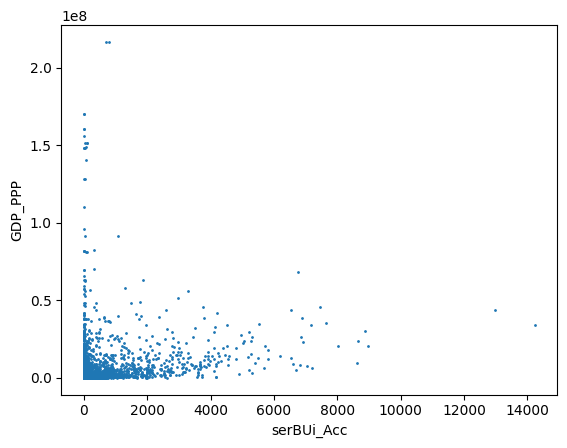

In [80]:
# Link between buildings and GDP
plt.scatter(grid['serBUi_Acc'], grid['GDP_PPP'],s=1)

# Add labels to the plot
plt.xlabel('serBUi_Acc')
plt.ylabel('GDP_PPP')

# Set the axis to logarithmic scale
# plt.yscale('log')
# plt.xscale('log')

# Show the plot
plt.show()

In [81]:
threshold_access = 0.1 # lower value than residential because easier to connect services buildings
alpha = 0
beta = 0
gama = 1

In [82]:
# compute weighted average
# Create a boolean Series indicating if probElec meets the condition
condition_met = grid[probElec] >= threshold_access
# Assign the weighted average based on the condition
grid['SEn_kWh_weighted'] = condition_met * (alpha * grid['SEn_kWh_GDP'] + beta * grid['SEn_kWh_bui'] + gama * grid['SEn_kWh_Emp'] )

totalSEn_kWh_weighted = grid['SEn_kWh_weighted'].sum()
grid['SEn_kWh_final'] = grid['SEn_kWh_weighted'] / totalSEn_kWh_weighted * total_servicesenergy_GWh *10**6 

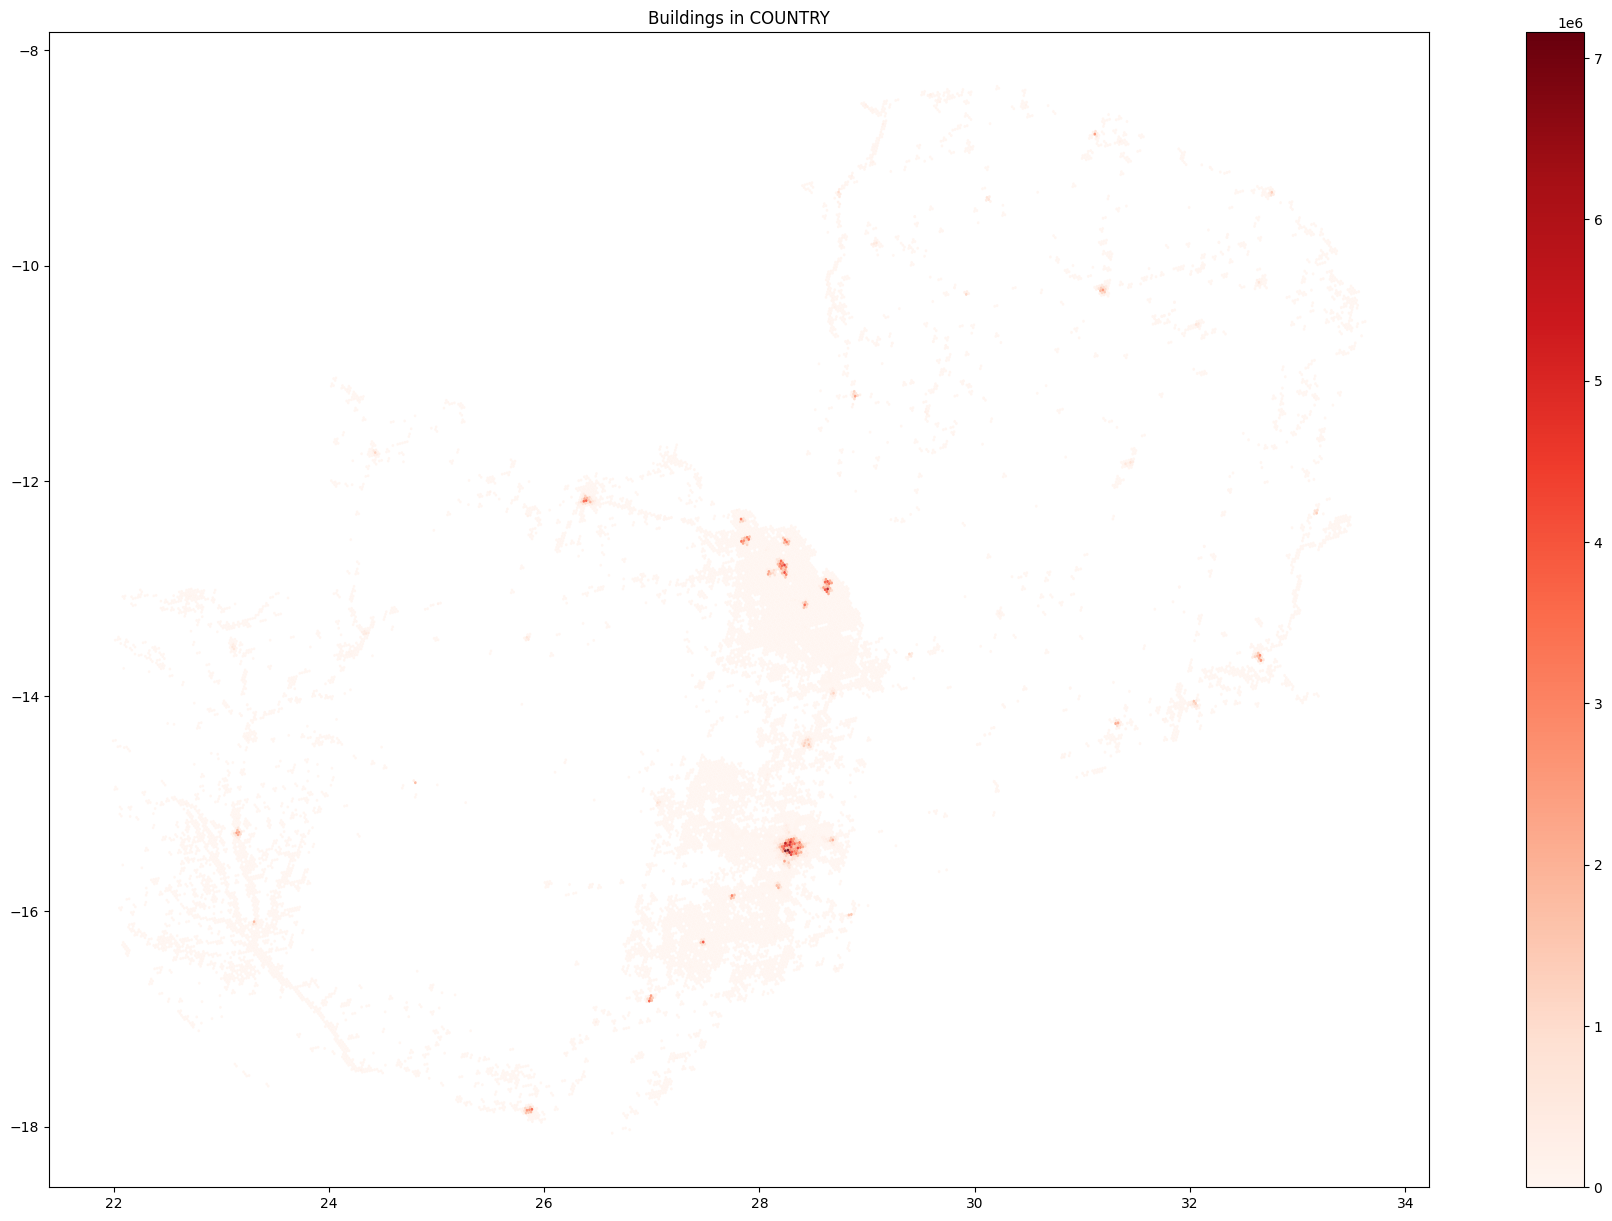

In [83]:
# Plot the energy consumption in services buildings map
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('SEn_kWh_final', ascending=True).plot(
    ax=ax, column='SEn_kWh_final', cmap="Reds", legend=True, alpha=0.9)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Buildings in {}'.format(area) )

# Save plot as figure 
plt.savefig('services_map' +str(alpha) +str(gama)+'.png', bbox_inches='tight')

In [84]:
grid.to_csv("dataser.csv")
grid.to_file(out_path + "\\" + 'ser_energy_map.shp', index=False)
grid.to_file(out_path + "\\" + f'ser_energy_map.geojson', driver='GeoJSON', index=False)  
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,...,SEn_kWh_bui,SEn_kWh_GDP,nb_women,nb_men,nb_women_working,nb_men_working,total_employee,SEn_kWh_Emp,SEn_kWh_weighted,SEn_kWh_final
0,87399485cffffff,30.52,-12.18,5.00,Muchinga,1,57.00,0.00,0.03,-0.81,...,380.06,NaN,15.41,13.87,1.26,2.87,4.13,"1,120.44",NaN,NaN
1,873995215ffffff,30.42,-10.43,7.00,Northern,2,NaN,NaN,NaN,-0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,87344b340ffffff,25.31,-16.22,8.00,Southern,3,NaN,NaN,0.09,-0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
total_servicesenergy_scaled = grid.groupby('NAME_1')['SEn_kWh_final'].sum() 
print ("Services electricity consumption assessed after scaling:")
for region in regions:
    total_servicesenergy_scaled[region] = total_servicesenergy_scaled[region]/10**6  # conversion in GWh
    print (region, f"{total_servicesenergy_scaled[region]:,.1f}", "GWh" )
print (total_servicesenergy_scaled )
print (total_servicesenergy_scaled.sum() )

Services electricity consumption assessed after scaling:
Copperbelt 194.1 GWh
Muchinga 12.1 GWh
North-Western 43.4 GWh
Western 24.5 GWh
Luapula 25.2 GWh
Northern 27.4 GWh
Central 56.5 GWh
Southern 66.9 GWh
Eastern 40.5 GWh
Lusaka 231.0 GWh
NAME_1
Central          56.47
Copperbelt      194.07
Eastern          40.48
Luapula          25.20
Lusaka          231.05
Muchinga         12.09
North-Western    43.44
Northern         27.39
Southern         66.94
Western          24.54
Name: SEn_kWh_final, dtype: float64
721.6666666666669


# Buildings

In [86]:
# total_Buienergy_scaled = total_servicesenergy_scaled + total_residentialenergy_scaled
total_Buienergy_scaled = total_servicesenergy_scaled + result_afterscaling['meth3']
print ("Services electricity consumption assessed after scaling:")
for region in regions:
    print (region, f"{total_Buienergy_scaled[region]:,.1f}", "GWh" )
print (total_Buienergy_scaled )

Services electricity consumption assessed after scaling:
Copperbelt 1,490.3 GWh
Muchinga 39.5 GWh
North-Western 217.5 GWh
Western 89.9 GWh
Luapula 60.4 GWh
Northern 132.4 GWh
Central 287.3 GWh
Southern 324.8 GWh
Eastern 160.2 GWh
Lusaka 1,941.9 GWh
NAME_1
Central           287.28
Copperbelt      1,490.27
Eastern           160.20
Luapula            60.44
Lusaka          1,941.88
Muchinga           39.54
North-Western     217.48
Northern          132.43
Southern          324.75
Western            89.90
dtype: float64
